In [1]:
import math
import nilearn as ni
from nilearn import plotting
from nilearn import image
from nilearn.image import math_img
from nilearn.image import index_img
from nilearn.regions import connected_regions
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import basinhopping

# Optimal Thresholding of Images
Load the Neurosynth images, then remove values < 0: 

In [82]:
wm = image.load_img("wm_map.nii")
action = image.load_img("motor_map.nii")
ltm = image.load_img("ltm_map.nii")
perception = image.load_img("perception_map.nii")
pm = image.load_img("procedural_map.nii")

wm = math_img("np.where(i<0,0,i)",i=wm)
action = math_img("np.where(i<0,0,i)",i=action)
ltm = math_img("np.where(i<0,0,i)",i=ltm)
perception = math_img("np.where(i<0,0,i)",i=perception)
pm = math_img("np.where(i<0,0,i)",i=pm)

IMAGES = [wm, ltm, action, pm,  perception]
NAMES = ["wm", "ltm", "action", "procedural", "perception"]

## What the maps look like

Here is what the maps look like, using the colors of the Stocco et al. (in press) paper:

/home/stocco/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


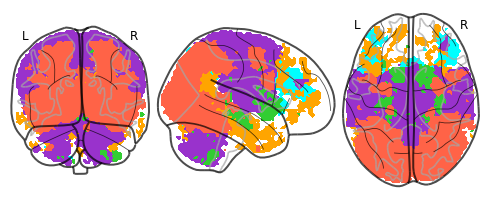

In [11]:
display = plotting.plot_glass_brain(None)
COLORS = ["aqua", "orange", "darkorchid", "limegreen", "tomato"]
for img, col in zip(IMAGES, COLORS):
    display.add_contours(img, levels=[0.0], filled=True, colors=col)

## Setting Up the Thresholding Procedure

Define some basic functions, one to create thresholded images based on proportion of maximum inhtensity, and one to create the sum of each image's binary masks

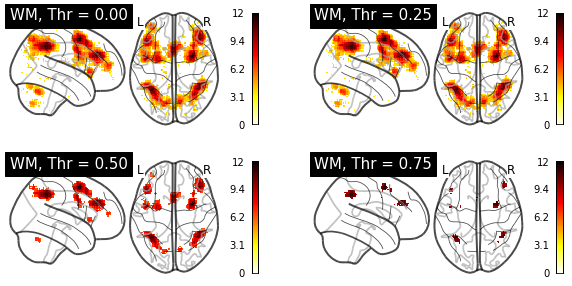

In [4]:
def percent_threshold(img, pc_threshold):
    """Thresholds an image at XX%"""
    v_max = np.max(img.dataobj)
    thr = v_max * pc_threshold
    return image.threshold_img(img, thr)

fig, axes = plt.subplots(2, 2, figsize=(10,5))
axes = [item for sublist in axes for item in sublist]
for i in range(0, 4):
    threshold = i/4.0
    plotting.plot_glass_brain(percent_threshold(wm, threshold), 
                              title="WM, Thr = %.2f" % threshold, 
                              display_mode='xz', axes=axes[i],
                              colorbar=True)

And now, a function that uses the threshold to create the Sum of Binary Masks (SBM):

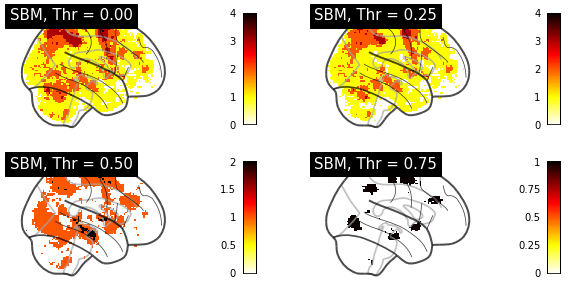

In [5]:
def sum_bin_masks(pc_threshold):
    """Calculates the sum of all binarized masks"""
    res = None
    if pc_threshold < 0:
        pc_threshold = 0
    if pc_threshold > 1:
        pc_threshold = 1
    for img in [wm, action, ltm, perception, pm]:
        partial = percent_threshold(img, pc_threshold)
        partial = math_img("np.where(i>0,1,0)", i = partial)
        if res == None:
            res = partial
        else:
            res = math_img("i1 + i2", i1=res, i2=partial)
    return res
                
        
fig, axes = plt.subplots(2, 2, figsize=(10,5))
axes = [item for sublist in axes for item in sublist]
for i in range(0, 4):
    threshold = i/4.0
    plotting.plot_glass_brain(sum_bin_masks(threshold), title="SBM, Thr = %.2f" % threshold, 
                              display_mode='x', axes=axes[i], colorbar=True)

## A General Loss Function
To define a loss function, it will be useful, later on, to refer to to total number of voxels $V_{SBM}$ that is present in the Summed Binary Mask when the height threshold is zero.

In [6]:
sbm0 = sum_bin_masks(0)
bsbm0 = math_img("np.where(i>0, 1, 0)", i = sbm0)
V_SBM = np.sum(bsbm0.dataobj)
V_SBM

84126

Now we can use Python's Optimization algorithm to find the best possible threshold). To do se, we need to define a loss function that needs to be minized. The loss function take as input the set of images created by apply different height and cluster thresholds (one for each of the five components), create binary mask versions of each of them, sum them up into a resulting Summed Binary Mask (SBM) image, and calculate a _loss_ value that is the sum of two penalties:

* A _size_ penalty, which is the ratio of the total number of voxels in the sum binary mask (SBM) at the final threshold and the total number of voxels in the SBM when the threshold is zero (that is, _V_(_H_=_H_*)/_V_(_H_=0)). This will push the algorithm the find the smallest possible threshold; and

* An _overlap_ penalty, which is maximum value of the intensity in the sum binary mask (SBM), i.e. the sum of the five binary masks, minus 1, i.e., |max(SBM)-1|. This will push the algorithm to reduce the overlap between masked images.

In addition, a third penalty value is added

* A _missing region_ penalty, which is equal to 1 for every one of the input regions that has no voxel remaining after applying the proper height and size thresholds.

To obtain properly smooth functions, the normalized form of the parameters will also be added.

### Implementation

To implement this procedure, we first need to define two functions, one that generates the SBM from the initial images and calculates the _missing region_ penalty, and one that calculates the overall loss function.  

In [7]:
def sbm_function(images):
    """Generates an SBM from component images and calculates the missing region penalty"""
    res = None
    missing_region_penalty = 0
    
    for img in images:
        partial = math_img("np.where(i>0,1,0)", i = img)
        
        # Check if all voxels have been removed
        if np.sum(partial.dataobj) == 0:
            missing_region_penalty += 1
        
        if res == None:
            res = partial
        else:
            res = math_img("i1 + i2", i1=res, i2=partial)
    
    return res, missing_region_penalty

def loss_function(images):
    """General loss function"""
    sbm, mr_penalty = sbm_function(images)
    
    H_max = np.max(sbm.dataobj)
    overlap_penalty = abs(H_max - 1)
    
    print("  --> Penalities: <MR: %d; OL: %d>" % (mr_penalty, overlap_penalty))
    
    bsbm = math_img("np.where(i>0, 1, 0)", i = sbm)
    size_penalty = 1.0 - np.sum(bsbm.dataobj)/float(V_SBM)
    
    return  overlap_penalty + size_penalty #+ mr_penalty

# 1. Optimization: Height Threshold

Finally, having defined a loss function, we can built a target function that calculates the loss based on a specific height threshold. We can then use standard optimization algorithms to minimize the loss. In this case, we will be Powell's method (as opposed to Nelder-Mead), which allows for linear bounds of the variables.

In [17]:
def pheight_threshold(x):
    """Objective function to minimize"""
    thr = x[0]
    images = [percent_threshold(img, thr) for img in IMAGES]
    loss = loss_function(images) + thr
    print("H = % .3f, Loss = %.3f" % (thr, loss))
    return loss 

optimal = minimize(pheight_threshold, np.array([0.4]), method="Powell",
                   bounds=[(0, 1)], options={"maxiter" : 200, "disp":True})

  --> Penalities: <MR: 0; OL: 2>
H =  0.400, Loss = 3.125
  --> Penalities: <MR: 0; OL: 2>
H =  0.382, Loss = 3.070
  --> Penalities: <MR: 0; OL: 1>
H =  0.618, Loss = 2.571
  --> Penalities: <MR: 0; OL: 0>
H =  0.764, Loss = 1.753
  --> Penalities: <MR: 0; OL: 0>
H =  0.854, Loss = 1.851
  --> Penalities: <MR: 0; OL: 0>
H =  0.790, Loss = 1.781
  --> Penalities: <MR: 0; OL: 1>
H =  0.708, Loss = 2.688
  --> Penalities: <MR: 0; OL: 0>
H =  0.743, Loss = 1.728
  --> Penalities: <MR: 0; OL: 0>
H =  0.729, Loss = 1.713
  --> Penalities: <MR: 0; OL: 1>
H =  0.721, Loss = 2.703
  --> Penalities: <MR: 0; OL: 0>
H =  0.735, Loss = 1.719
  --> Penalities: <MR: 0; OL: 0>
H =  0.726, Loss = 1.709
  --> Penalities: <MR: 0; OL: 0>
H =  0.724, Loss = 1.707
  --> Penalities: <MR: 0; OL: 0>
H =  0.723, Loss = 1.706
  --> Penalities: <MR: 0; OL: 0>
H =  0.723, Loss = 1.705
  --> Penalities: <MR: 0; OL: 0>
H =  0.722, Loss = 1.704
  --> Penalities: <MR: 0; OL: 0>
H =  0.722, Loss = 1.704
  --> Penaliti

/home/stocco/anaconda3/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:68: UserWarning: The given float value must not exceed 12.496480784057677. But, you have given threshold=13.031971404959247 
  warnings.warn("The given float value must not exceed {0}. "
/home/stocco/anaconda3/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:68: UserWarning: The given float value must not exceed 13.272106979793879. But, you have given threshold=13.840834202289088 
  warnings.warn("The given float value must not exceed {0}. "
/home/stocco/anaconda3/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:68: UserWarning: The given float value must not exceed 22.452058419896012. But, you have given threshold=23.414158623268992 
  warnings.warn("The given float value must not exceed {0}. "
/home/stocco/anaconda3/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:68: UserWarning: The given float value must not exceed 7.783933232641721. But, you have given t

  --> Penalities: <MR: 5; OL: 1>
H =  1.043, Loss = 3.043
  --> Penalities: <MR: 0; OL: 2>
H =  0.382, Loss = 3.070
  --> Penalities: <MR: 0; OL: 1>
H =  0.618, Loss = 2.571
  --> Penalities: <MR: 0; OL: 0>
H =  0.764, Loss = 1.753
  --> Penalities: <MR: 0; OL: 0>
H =  0.854, Loss = 1.851
  --> Penalities: <MR: 0; OL: 0>
H =  0.790, Loss = 1.781
  --> Penalities: <MR: 0; OL: 1>
H =  0.708, Loss = 2.688
  --> Penalities: <MR: 0; OL: 0>
H =  0.743, Loss = 1.728
  --> Penalities: <MR: 0; OL: 0>
H =  0.729, Loss = 1.713
  --> Penalities: <MR: 0; OL: 1>
H =  0.721, Loss = 2.703
  --> Penalities: <MR: 0; OL: 0>
H =  0.735, Loss = 1.719
  --> Penalities: <MR: 0; OL: 0>
H =  0.726, Loss = 1.709
  --> Penalities: <MR: 0; OL: 0>
H =  0.724, Loss = 1.707
  --> Penalities: <MR: 0; OL: 0>
H =  0.723, Loss = 1.706
  --> Penalities: <MR: 0; OL: 0>
H =  0.723, Loss = 1.705
  --> Penalities: <MR: 0; OL: 0>
H =  0.722, Loss = 1.704
  --> Penalities: <MR: 0; OL: 0>
H =  0.722, Loss = 1.704
  --> Penaliti

## Visualization of results


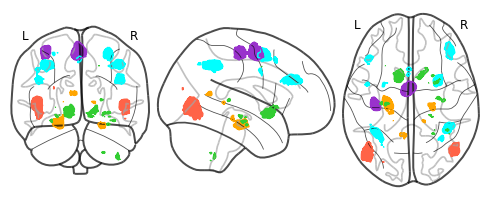

In [18]:
display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    thr = optimal.x[0] * np.max(img.dataobj)
    display.add_contours(img, levels=[thr], filled=True, colors=col)

# 2. Optimizing Threshold _and_ Cluster Size

Now, we are applying the same principles but we optimize along two different axes: threshold and cluster size. To do so, we need to use the `nistats` functions, which are now part of nilearn, and redefine `percent_threshold` and `bin_mask_sum` as two-argument functions.

In [9]:
import nilearn.glm as glm

def pheight_cluster_threshold(img, ph_threshold, clust_threshold):
    """Thresholds an image at XX% with clusters of extend > NN"""
    v_max = np.max(img.dataobj)
    thr = v_max * ph_threshold
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=thr, 
                                     cluster_threshold=clust_threshold,
                                     height_control=None)
    return res


And now, we define a new objective function. The loss function is the same as before (penalty for overlap plus penalty for decreased number of voxels across masks) but now the SBM is calculated using a proportional height and an absolute cluster size 

In [20]:
def pheight_cluster_target(x):
    """Objective function to minimize"""
    pH = x[0]
    C = int(x[1])
    images = [pheight_cluster_threshold(img, pH, C) for img in IMAGES]
    loss = loss_function(images) + pH + C/1000
    print("H = % .4f, C = %d, Loss = %.4f" % (pH, C, loss))
    return loss 

optimal2 = minimize(pheight_cluster_target, np.array([0.5, 50]), method="Powell", 
                    bounds=[(0, 1), (0, 1000)], options={"maxiter" : 200, "maxfev" : 200,
                                                         "disp" : True, 
                                                         "ftol" : 0.001, "xtol" : 0.001})



  --> Penalities: <MR: 0; OL: 1>
H =  0.5000, C = 50, Loss = 2.4307
  --> Penalities: <MR: 0; OL: 1>
H =  0.3820, C = 50, Loss = 2.1335
  --> Penalities: <MR: 0; OL: 0>
H =  0.6180, C = 50, Loss = 1.6288
  --> Penalities: <MR: 0; OL: 0>
H =  0.7639, C = 50, Loss = 1.8041
  --> Penalities: <MR: 0; OL: 0>
H =  0.6223, C = 50, Loss = 1.6341
  --> Penalities: <MR: 0; OL: 1>
H =  0.5279, C = 50, Loss = 2.4826
  --> Penalities: <MR: 0; OL: 1>
H =  0.5836, C = 50, Loss = 2.5765
  --> Penalities: <MR: 0; OL: 1>
H =  0.6049, C = 50, Loss = 2.6102
  --> Penalities: <MR: 0; OL: 1>
H =  0.6130, C = 50, Loss = 2.6207
  --> Penalities: <MR: 0; OL: 0>
H =  0.6161, C = 50, Loss = 1.6252
  --> Penalities: <MR: 0; OL: 0>
H =  0.6149, C = 50, Loss = 1.6236
  --> Penalities: <MR: 0; OL: 0>
H =  0.6142, C = 50, Loss = 1.6227
  --> Penalities: <MR: 0; OL: 1>
H =  0.6137, C = 50, Loss = 2.6216
  --> Penalities: <MR: 0; OL: 0>
H =  0.6145, C = 50, Loss = 1.6231
  --> Penalities: <MR: 3; OL: 0>
H =  0.6142, C 

## Visualization

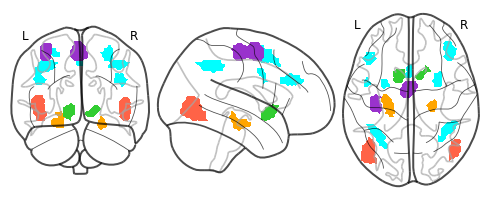

In [21]:
display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    thr = optimal2.x[0] * np.max(img.dataobj)
    clust = optimal2.x[1]
    newimg, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=thr, 
                                        cluster_threshold=clust, height_control=None)
    display.add_contours(newimg, levels=[0.001], filled=True, colors=col)

# 3. Optimizing _only_ Cluster Size

We can rightfully ask, what would happen if we optimized _only_ for cluster size?

In [22]:
def cluster_threshold(img, clust_threshold):
    """Thresholds an image at XX% with clusters of extend > NN"""
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=0.00001, 
                                     cluster_threshold=clust_threshold, height_control=None)
    return res

def cluster_target(x):
    """Objective function to minimize"""
    C = int(x[0])
    images = [cluster_threshold(img, C) for img in IMAGES]
    loss = loss_function(images) + x/2000
    print("C = %d, Loss = %.4f" % (C, loss))
    return loss 

optimal3 = minimize(cluster_target, np.array([10]), method="Powell", bounds=[(0, 2000)], 
                    options={"maxiter" : 200, "disp":True})



  --> Penalities: <MR: 0; OL: 2>
C = 10, Loss = 2.0223
  --> Penalities: <MR: 1; OL: 2>
C = 763, Loss = 2.4664
  --> Penalities: <MR: 1; OL: 2>
C = 1236, Loss = 2.7157
  --> Penalities: <MR: 1; OL: 2>
C = 472, Loss = 2.3133
  --> Penalities: <MR: 0; OL: 2>
C = 291, Loss = 2.2121
  --> Penalities: <MR: 0; OL: 2>
C = 180, Loss = 2.1416
  --> Penalities: <MR: 0; OL: 2>
C = 111, Loss = 2.0999
  --> Penalities: <MR: 0; OL: 2>
C = 68, Loss = 2.0737
  --> Penalities: <MR: 0; OL: 2>
C = 42, Loss = 2.0519
  --> Penalities: <MR: 0; OL: 2>
C = 26, Loss = 2.0366
  --> Penalities: <MR: 0; OL: 2>
C = 16, Loss = 2.0286
  --> Penalities: <MR: 0; OL: 2>
C = 10, Loss = 2.0224
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0182
  --> Penalities: <MR: 0; OL: 3>
C = 3, Loss = 3.0134
  --> Penalities: <MR: 0; OL: 2>
C = 7, Loss = 2.0196
  --> Penalities: <MR: 0; OL: 3>
C = 5, Loss = 3.0167
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0185


/home/stocco/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  --> Penalities: <MR: 0; OL: 3>
C = 5, Loss = 3.0171
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0183
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0182
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0182
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 3>
C = 5, Loss = 3.0171
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 3>
C = 5, Loss = 3.0171
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 3>
C = 5, Loss = 3.0171
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 3>
C = 5, Loss = 3.0171
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL: 2>
C = 6, Loss = 2.0181
  --> Penalities: <MR: 0; OL

## Visualization

Unfortunately, we cannot eliminate overlap...

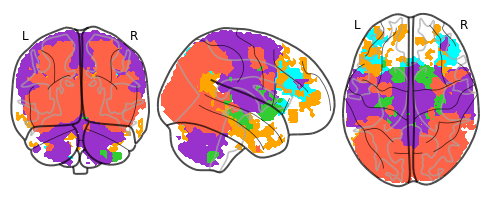

In [23]:
display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    clust = optimal3.x[0]
    newimg, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=0.0001, 
                                        cluster_threshold=clust, height_control=None)
    display.add_contours(newimg, levels=[0.001], filled=True, colors=col)

# 4. Optimizing Cluster Size, but Proportionally 

What if we apply to the cluster threshold the same principle we applied to the height threshold, i.e. we scale it based on the specifics of each mask? In this case, we can imagine setting the cluster size _C_ to a value 0 < _C_ < 1 that represents the fraction of the total number of voxels in the mask.

  --> Penalities: <MR: 3; OL: 1>
C = 0.7500, Loss = 2.0755
  --> Penalities: <MR: 2; OL: 1>
C = 0.3820, Loss = 1.6307
  --> Penalities: <MR: 3; OL: 1>
C = 0.6180, Loss = 1.9435
  --> Penalities: <MR: 2; OL: 1>
C = 0.2361, Loss = 1.4848
  --> Penalities: <MR: 0; OL: 2>
C = 0.1459, Loss = 2.2528
  --> Penalities: <MR: 2; OL: 1>
C = 0.2918, Loss = 1.5405
  --> Penalities: <MR: 0; OL: 1>
C = 0.2016, Loss = 1.4205
  --> Penalities: <MR: 0; OL: 1>
C = 0.1803, Loss = 1.3992
  --> Penalities: <MR: 0; OL: 2>
C = 0.1588, Loss = 2.2778
  --> Penalities: <MR: 0; OL: 2>
C = 0.1721, Loss = 2.2911
  --> Penalities: <MR: 0; OL: 1>
C = 0.1885, Loss = 1.4074
  --> Penalities: <MR: 0; OL: 1>
C = 0.1772, Loss = 1.3075
  --> Penalities: <MR: 0; OL: 2>
C = 0.1753, Loss = 2.2943
  --> Penalities: <MR: 0; OL: 1>
C = 0.1784, Loss = 1.3087
  --> Penalities: <MR: 0; OL: 1>
C = 0.1778, Loss = 1.3080
  --> Penalities: <MR: 0; OL: 2>
C = 0.1765, Loss = 2.2955
  --> Penalities: <MR: 0; OL: 2>
C = 0.1769, Loss = 2.29

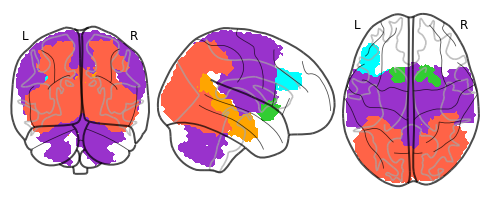

In [24]:
def pcluster_threshold(img, pclust_threshold):
    """Thresholds an image at XX% with clusters of extend > NN"""
    b_img = math_img("np.where(i>0,1,0)", i = img)
    N = np.sum(b_img.dataobj)
    C = int(pclust_threshold * float(N))
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=0.00001, 
                                     cluster_threshold=C, height_control=None)
    return res


def pcluster_target(x):
    """Objective function to minimize"""
    C = x[0]
    images = [pcluster_threshold(img, C) for img in IMAGES]
    loss = loss_function(images) + C
    print("C = %.4f, Loss = %.4f" % (C, loss))
    return loss 

optimal4 = minimize(pcluster_target, np.array([0.75]), method="Powell", 
                    bounds=[(0,1)], options={"maxiter" : 200, "disp":True})

# Visualization

display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    clust = optimal4.x[0]
    b_img = math_img("np.where(i>0,1,0)", i = img)
    N = np.sum(b_img.dataobj)
    C = int(clust * N)
    newimg, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=0.01, 
                                        cluster_threshold=C, height_control=None)
    display.add_contours(newimg, levels=[0.001], filled=True, colors=col)

# 5. Proportional Threshold and Proportional Clustering

Here we optimize both parameters proportionally, the height threshold _H_ and the cluster threshold _C_. The total amount of voxels _N_ on which the cluster size _C_ is computed is calculated only after applying the height threshold _H_, to avoid paradoxical situations in which the cluster size is larger than the remaining number of voxels. 

  --> Penalities: <MR: 4; OL: 0>
H =  0.5000, C = 0.5000, Loss = 1.9799
  --> Penalities: <MR: 2; OL: 1>
H =  0.3820, C = 0.5000, Loss = 2.5841
  --> Penalities: <MR: 3; OL: 0>
H =  0.6180, C = 0.5000, Loss = 2.2239
  --> Penalities: <MR: 1; OL: 0>
H =  0.7639, C = 0.5000, Loss = 2.5221
  --> Penalities: <MR: 2; OL: 0>
H =  0.5816, C = 0.5000, Loss = 2.1424
  --> Penalities: <MR: 4; OL: 0>
H =  0.5054, C = 0.5000, Loss = 1.9915
  --> Penalities: <MR: 5; OL: 1>
H =  0.4582, C = 0.5000, Loss = 2.9165
  --> Penalities: <MR: 4; OL: 0>
H =  0.5345, C = 0.5000, Loss = 2.0534
  --> Penalities: <MR: 5; OL: 1>
H =  0.4874, C = 0.5000, Loss = 2.9747
  --> Penalities: <MR: 4; OL: 0>
H =  0.5165, C = 0.5000, Loss = 2.0152
  --> Penalities: <MR: 4; OL: 0>
H =  0.4985, C = 0.5000, Loss = 1.9767
  --> Penalities: <MR: 4; OL: 0>
H =  0.4942, C = 0.5000, Loss = 1.9676
  --> Penalities: <MR: 4; OL: 0>
H =  0.4916, C = 0.5000, Loss = 1.9621
  --> Penalities: <MR: 4; OL: 0>
H =  0.4900, C = 0.5000, Loss =

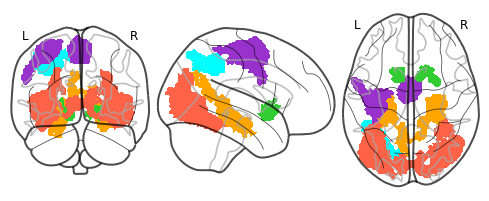

In [25]:
def pheight_pcluster_threshold(img, pheight, pclust):
    """Thresholds an image at XX% with clusters of extend > NN"""
    v_max = np.max(img.dataobj)
    H = v_max * pheight
    
    # Calculate the correct C threshold on the surviving voxels
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                     cluster_threshold=1, height_control=None)
    
    b_res = math_img("np.where(i>0,1,0)", i = res)
    C = int(pclust * float(np.sum(b_res.dataobj)))
    
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                     cluster_threshold=C, height_control=None)
    return res


def pheight_pcluster_target(x):
    """Objective function to minimize"""
    pH = x[0]
    pC = x[1]
    
    images = [pheight_pcluster_threshold(img, pH, pC) for img in IMAGES]
    loss = loss_function(images) + pH + pH
    
    print("H = % .4f, C = %.4f, Loss = %.4f" % (pH, pC, loss))
    return loss 

optimal5 = minimize(pheight_pcluster_target, np.array([0.5, 0.5]), method="Powell", 
                    bounds=[(0,1), (0,1)], options={"maxiter" : 200, "disp":True})

#optimal5 = basinhopping(pheight_pcluster_target, np.array([0.2, 0.1]))

display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    H = optimal5.x[0]
    C = optimal5.x[1]
    
    v_max = np.max(img.dataobj)
    H = v_max * H
    
    # Calculate the correct C threshold on the surviving voxels
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                     cluster_threshold=1, height_control=None)
    
    b_res = math_img("np.where(i>0,1,0)", i = res)
    C = int(C * float(np.sum(b_res.dataobj)))
    
    newimg, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                        cluster_threshold=C, height_control=None)
    display.add_contours(newimg, levels=[0.001], filled=True, colors=col)

# 6. Absolute Height and Proportional Clustering Thresholds

The last combination of parameters, where the height threshold _H_ is optimized on an absolute scale and the cluster threshold _C_ is optimized proportionally. The total amount of voxels _N_ on which the cluster size _C_ is computed is calculated only after applying the height threshold _H_, to avoid paradoxical situations in which the cluster size is larger than the remaining number of voxels. 

  --> Penalities: <MR: 0; OL: 3>
H =  10.0000, C = 0.5000, Loss = 4.0368
  --> Penalities: <MR: 0; OL: 3>
H =  10.5000, C = 0.5000, Loss = 4.0538
  --> Penalities: <MR: 0; OL: 2>
H =  10.0000, C = 0.5250, Loss = 3.0647
  --> Penalities: <MR: 0; OL: 2>
H =  9.5000, C = 0.5250, Loss = 3.0417
  --> Penalities: <MR: 0; OL: 2>
H =  9.0000, C = 0.5375, Loss = 3.0388
  --> Penalities: <MR: 0; OL: 2>
H =  9.0000, C = 0.5625, Loss = 3.0638
  --> Penalities: <MR: 0; OL: 2>
H =  8.0000, C = 0.5750, Loss = 3.0362
  --> Penalities: <MR: 0; OL: 2>
H =  7.0000, C = 0.6000, Loss = 3.0290
  --> Penalities: <MR: 0; OL: 2>
H =  7.0000, C = 0.5750, Loss = 2.9962
  --> Penalities: <MR: 0; OL: 2>
H =  6.0000, C = 0.5812, Loss = 3.0867
  --> Penalities: <MR: 1; OL: 1>
H =  5.0000, C = 0.6375, Loss = 2.1290
  --> Penalities: <MR: 3; OL: 1>
H =  3.0000, C = 0.6875, Loss = 2.1630
  --> Penalities: <MR: 1; OL: 1>
H =  5.0000, C = 0.6125, Loss = 2.1040
  --> Penalities: <MR: 2; OL: 1>
H =  4.0000, C = 0.6187, Los

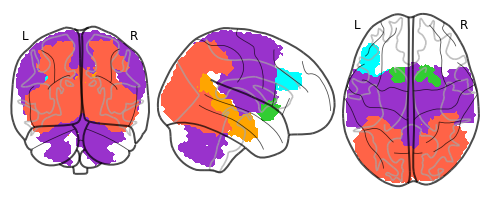

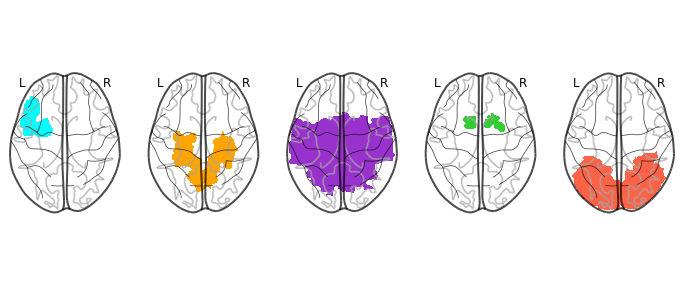

In [34]:
def height_pcluster_threshold(img, height, pclust_threshold):
    """Thresholds with absolute height threshold and proportional cluster threshold"""    
    # Apply H threshold first
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=height, 
                                     cluster_threshold=1, height_control=None)
    
    # Calculate the correct C threshold on the surviving voxels
    b_res = math_img("np.where(i>0,1,0)", i = res)
    C = math.ceil(int(pclust_threshold * float(np.sum(b_res.dataobj))))
    
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                     cluster_threshold=C, height_control=None)
    return res


def height_pcluster_target(x):
    """Objective function to minimize"""
    H = x[0]
    pC = x[1]
    
    images = [height_pcluster_threshold(img, H, pC) for img in IMAGES]
    loss = loss_function(images) + abs(H/20) + abs(pC)

    print("H = % .4f, C = %.4f, Loss = %.4f" % (H, pC, loss))
    return loss

optimal6 = minimize(height_pcluster_target, np.array([10, 0.5]), method="Nelder-Mead",
                    bounds=[(0, 20), (0, 1)], options={"maxiter" : 200, "disp":True})

# Visualization

display = plotting.plot_glass_brain(None)

fig, axs = plt.subplots(1, 5, figsize=(12,5))
i = 0

for img, col in zip(IMAGES, COLORS):
    H = optimal6.x[0]
    C = optimal6.x[1]
        
    # Calculate the correct C threshold on the surviving voxels
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                     cluster_threshold=1, height_control=None)
    
    b_res = math_img("np.where(i>0,1,0)", i = res)
    C = int(C * float(np.sum(b_res.dataobj)))
    
    newimg, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                        cluster_threshold=C, height_control=None)
    display.add_contours(newimg, levels=[0.001], filled=True, colors=col)
    
    d = plotting.plot_glass_brain(None, axes=axs[i], display_mode='z')
    d.add_contours(newimg, levels=[0.001], filled=True, colors=col)
    
    i += 1

# 8. Proportional Height and Cluster, By Max Cluster Extent

  --> Penalities: <MR: 0; OL: 2>
H =  0.1000, C = 0.6000, Loss = 2.9077
  --> Penalities: <MR: 0; OL: 1>
H =  0.3820, C = 0.6000, Loss = 2.7803
  --> Penalities: <MR: 0; OL: 0>
H =  0.6180, C = 0.6000, Loss = 2.1900
  --> Penalities: <MR: 0; OL: 0>
H =  0.7639, C = 0.6000, Loss = 2.3556
  --> Penalities: <MR: 0; OL: 0>
H =  0.6314, C = 0.6000, Loss = 2.2028
  --> Penalities: <MR: 1; OL: 0>
H =  0.5279, C = 0.6000, Loss = 2.0684
  --> Penalities: <MR: 1; OL: 0>
H =  0.4721, C = 0.6000, Loss = 1.9847
  --> Penalities: <MR: 0; OL: 0>
H =  0.4377, C = 0.6000, Loss = 1.9108
  --> Penalities: <MR: 0; OL: 0>
H =  0.4164, C = 0.6000, Loss = 1.8660
  --> Penalities: <MR: 0; OL: 1>
H =  0.4033, C = 0.6000, Loss = 2.8307
  --> Penalities: <MR: 0; OL: 0>
H =  0.4245, C = 0.6000, Loss = 1.8848
  --> Penalities: <MR: 0; OL: 0>
H =  0.4114, C = 0.6000, Loss = 1.8550
  --> Penalities: <MR: 0; OL: 0>
H =  0.4083, C = 0.6000, Loss = 1.8484
  --> Penalities: <MR: 0; OL: 0>
H =  0.4064, C = 0.6000, Loss =

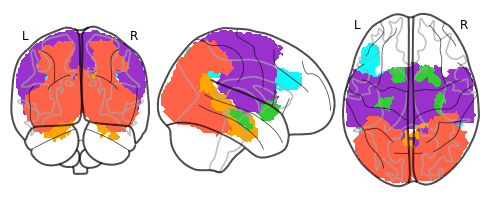

In [17]:
def max_cluster_extent(img):
    if np.max(img.dataobj) == 0:
        return 0
    else:
        clusts = connected_regions(img, 0)
        if len(clusts) > 0:
            clusts = clusts[0]
        clusters = [index_img(clusts, ii) for ii in range(clusts.dataobj.shape[3])]
        bclusters = [math_img("np.where(i>0,1,0)", i=x) for x in clusters]
        return np.max([np.sum(x.dataobj) for x in bclusters])

def total_extent(img):
    bimg = math_img("np.where(i>0,1,0)", i=img)
    return np.sum(bimg.dataobj)


def pheight_ppcluster_threshold(img, pheight, ppclust_threshold):
    """Thresholds with absolute height threshold and proportional cluster threshold"""    
    v_max = np.max(img.dataobj)
    pH = v_max * pheight
    
    # Apply H threshold first
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=pH, 
                                     cluster_threshold=1, height_control=None)
    
    # Calculate the correct C threshold on the surviving voxels
    #b_res = math_img("np.where(i>0,1,0)", i = res)
    ppC = math.ceil(int(ppclust_threshold * max_cluster_extent(res)))
    
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=pH, 
                                     cluster_threshold=ppC, height_control=None)
    return res


def pheight_ppcluster_target(x):
    """Objective function to minimize"""
    pH = x[0]
    ppC = x[1]
    
    images = [pheight_ppcluster_threshold(img, pH, ppC) for img in IMAGES]
    loss = loss_function(images) + pH + ppC

    print("H = % .4f, C = %.4f, Loss = %.4f" % (pH, ppC, loss))
    return loss 

optimal7 = minimize(pheight_ppcluster_target, np.array([0.1, 0.6]), method="Powell",
                    bounds=[(0, 1), (0, 1)], options={"maxiter" : 200, "disp":True})

display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    H = optimal7.x[0]
    C = optimal7.x[1]
        
    # Calculate the correct C threshold on the surviving voxels
    res, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                     cluster_threshold=1, height_control=None)
    
    b_res = math_img("np.where(i>0,1,0)", i = res)
    #C = int(C * float(np.sum(b_res.dataobj)))
    C = math.ceil(int(C * max_cluster_extent(res)))
    
    newimg, z = glm.threshold_stats_img(img, alpha=0.9999, threshold=H, 
                                        cluster_threshold=C, height_control=None)
    display.add_contours(newimg, levels=[0.001], filled=True, colors=col)

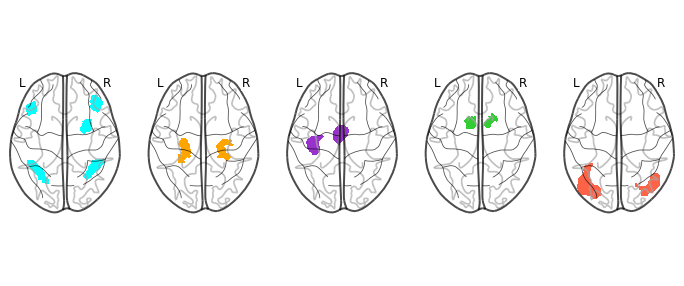

In [95]:
fig, axs = plt.subplots(1, 5, figsize=(12,5))
i = 0
H = optimal7.x[0]
C = optimal7.x[1]
images = [pheight_ppcluster_threshold(img, H, C) for img in IMAGES]
for img, col in zip(images, COLORS):   
    d = plotting.plot_glass_brain(None, axes=axs[i], display_mode='z')
    d.add_contours(img, levels=[0.001], filled=True, colors=col)
    
    i += 1

In [96]:
for img, name in zip(images, NAMES): 
    img.to_filename("%s_optimized.nii" % name)

In [57]:
def pheight_ppcluster_target(x):
    """Objective function to minimize"""
    pH = x[0]
    ppC = x[1]
    
    images = [pheight_ppcluster_threshold(img, pH, ppC) for img in IMAGES]
    loss = loss_function(images) 

    print("H = % .4f, C = %.4f, Loss = %.4f" % (pH, ppC, loss))
    return loss 

mat = np.zeros((9,9))
for h in list(np.linspace(0, 0.8, 9)):
    for c in list(np.linspace(0, 0.8, 9)):
        i = round(h*10) - 1
        j = round(c*10) - 1
        L = pheight_ppcluster_target(np.array([h, c]))
        mat[j,i] = L

  --> Penalities: <MR: 0; OL: 3>
H =  0.0000, C = 0.0000, Loss = 3.0000
  --> Penalities: <MR: 0; OL: 2>
H =  0.0000, C = 0.1000, Loss = 2.0683
  --> Penalities: <MR: 0; OL: 2>
H =  0.0000, C = 0.2000, Loss = 2.0758
  --> Penalities: <MR: 0; OL: 2>
H =  0.0000, C = 0.3000, Loss = 2.1708
  --> Penalities: <MR: 0; OL: 2>
H =  0.0000, C = 0.4000, Loss = 2.1785
  --> Penalities: <MR: 0; OL: 2>
H =  0.0000, C = 0.5000, Loss = 2.1953
  --> Penalities: <MR: 0; OL: 2>
H =  0.0000, C = 0.6000, Loss = 2.2077
  --> Penalities: <MR: 0; OL: 1>
H =  0.0000, C = 0.7000, Loss = 1.2189
  --> Penalities: <MR: 1; OL: 1>
H =  0.0000, C = 0.8000, Loss = 1.2415
  --> Penalities: <MR: 0; OL: 3>
H =  0.1000, C = 0.0000, Loss = 3.0000
  --> Penalities: <MR: 0; OL: 2>
H =  0.1000, C = 0.1000, Loss = 2.0683
  --> Penalities: <MR: 0; OL: 2>
H =  0.1000, C = 0.2000, Loss = 2.0758
  --> Penalities: <MR: 0; OL: 2>
H =  0.1000, C = 0.3000, Loss = 2.1708
  --> Penalities: <MR: 0; OL: 2>
H =  0.1000, C = 0.4000, Loss =

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

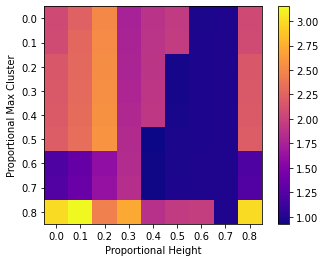

In [99]:
import matplotlib.pyplot as plt
labels = [round(x,2) for x in np.linspace(0, 0.8, 9)]
fig, ax = plt.subplots(1,1)
im = ax.imshow(mat, cmap="plasma")
plt.xticks(list(range(0,9)))
plt.yticks(list(range(0,9)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel("Proportional Max Cluster")
ax.set_xlabel("Proportional Height")
fig.colorbar(im)
labels

In [98]:
mat[6,0]

1.2189097306421321

### Save data 